In [1]:
import qiskit
from qiskit import QuantumCircuit, execute, Aer
from qiskit import pulse, transpile, schedule
from qiskit.pulse.library import Gaussian
from qiskit.providers.fake_provider import FakeValencia
import numpy as np
from qiskit.circuit import Gate, Parameter
import matplotlib.pyplot as plt
from qiskit.pulse.library import Drag
from qiskit.visualization import plot_histogram

In [2]:
backend = FakeValencia()

In a previous code we found the optimal value for the amplitude for the X gate in FakeValencia(). Let´s use this to create a T1 experiment with qiskit pulse

In [3]:
amp_optimal = 0.16953436127947377

In [4]:
backend_prop = backend.properties()
print("Configuration dictionary:", backend_prop.to_dict())

Configuration dictionary: {'backend_name': 'ibmq_valencia', 'backend_version': '1.4.6', 'last_update_date': datetime.datetime(2021, 1, 20, 4, 21, 6, tzinfo=tzoffset(None, -18000)), 'qubits': [[{'date': datetime.datetime(2021, 1, 19, 4, 5, 18, tzinfo=tzoffset(None, -18000)), 'name': 'T1', 'unit': 'us', 'value': 92.787570546235}, {'date': datetime.datetime(2021, 1, 20, 4, 6, 26, tzinfo=tzoffset(None, -18000)), 'name': 'T2', 'unit': 'us', 'value': 36.53696901735838}, {'date': datetime.datetime(2021, 1, 20, 4, 21, 6, tzinfo=tzoffset(None, -18000)), 'name': 'frequency', 'unit': 'GHz', 'value': 4.74390953476007}, {'date': datetime.datetime(2021, 1, 20, 4, 21, 6, tzinfo=tzoffset(None, -18000)), 'name': 'anharmonicity', 'unit': 'GHz', 'value': -0.31386048358781926}, {'date': datetime.datetime(2021, 1, 20, 4, 5, 25, tzinfo=tzoffset(None, -18000)), 'name': 'readout_error', 'unit': '', 'value': 0.03479999999999994}, {'date': datetime.datetime(2021, 1, 20, 4, 5, 25, tzinfo=tzoffset(None, -18000)),

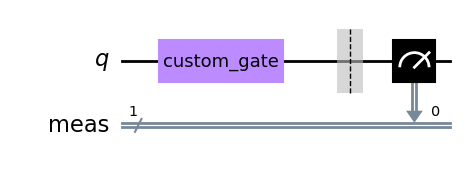

In [5]:
circuit = QuantumCircuit(1)
custom_gate = Gate('custom_gate', 1, [])
circuit.append(custom_gate, [0])
circuit.measure_all()
circuit.draw('mpl')

C:\Users\pedro\anaconda3\envs\qiskit-39\lib\site-packages\qiskit_aer\pulse\controllers\pulse_controller.py:144: UserWarning: Warning: qubit_lo_freq was not specified in PulseQobj and there is no default, so it is being automatically determined from the drift Hamiltonian.
  warn('Warning: qubit_lo_freq was not specified in PulseQobj and there is no default, '


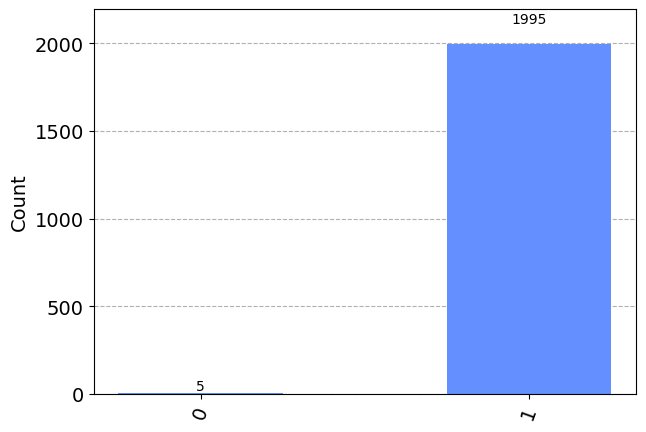

In [6]:
i = amp_optimal
amp = Parameter('amp')
from qiskit.pulse.library import Drag # the pulse library has predefined pulse shapes, such as Drag, Gaussian, etc.

with pulse.build(backend, name = 'custom_x') as my_sched:
    pulse.play(Drag(duration = 160, sigma = 40, amp = amp, beta =-0.25388969010654494 ), pulse.DriveChannel(0))

my_sched.assign_parameters({amp:i})


circuit.add_calibration(custom_gate, [0], my_sched)

circuit_transpile = transpile(circuit, backend)

schedule_circuit = schedule(circuit_transpile, backend)

job = backend.run(schedule_circuit, shots = 2000)
pl = job.result().get_counts()
plot_histogram(pl)

In [7]:
us = 1e-6

In [8]:
# T1 experiment parameters
time_max_sec = 450 * us
time_step_sec = 6.5 * us
delay_times_sec = np.arange(1 * us, time_max_sec, time_step_sec)
delay_dt = [int(i*45e8) for i in delay_times_sec]

In [10]:
delay = Parameter('delay')
qc_t1 = QuantumCircuit(1, 1)

qc_t1.x(0)
qc_t1.delay(delay, 0)
qc_t1.measure(0, 0)
qc_t1.add_calibration("x", [0], my_sched)

exp_t1_circs = [qc_t1.assign_parameters({delay: d}, inplace=False) for d in delay_dt]

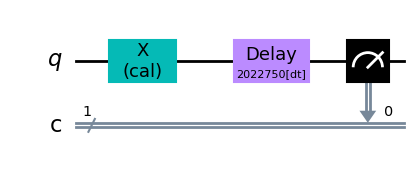

In [11]:
exp_t1_circs[-1].draw('mpl')

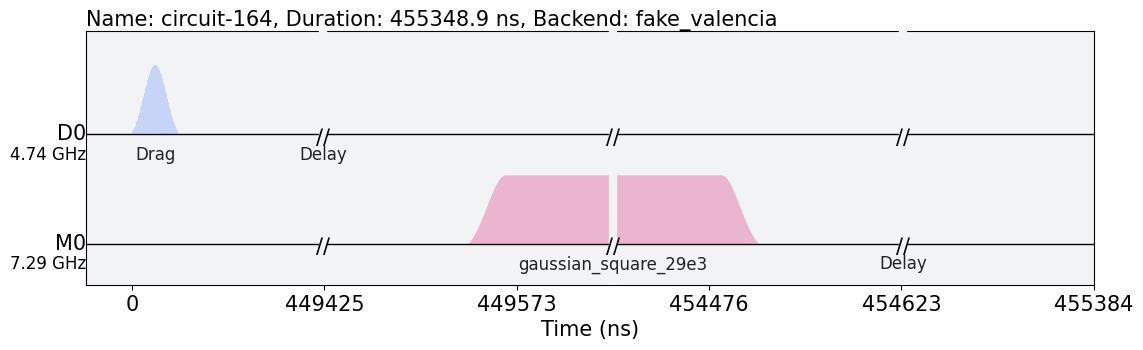

In [12]:
sched_idx = -1
t1_schedule = schedule(exp_t1_circs[sched_idx], backend)
t1_schedule.draw(backend=backend)

In [13]:
# Execution settings
num_shots = 256

job = backend.run(exp_t1_circs, shots=num_shots)



In [14]:
t1_results = job.result(timeout=120).get_counts()

In [15]:
prob_1 = [i['1']/sum(i.values()) for i in t1_results]

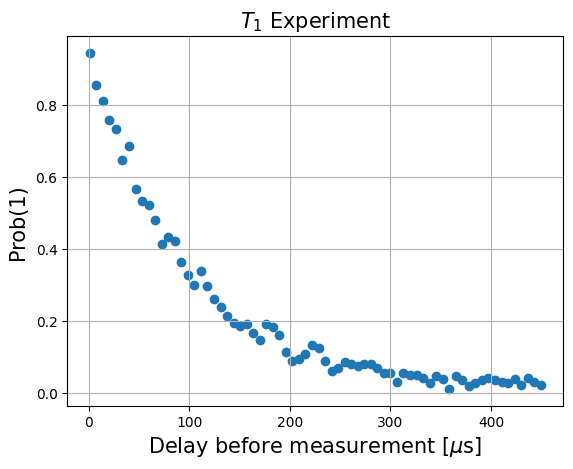

In [16]:
t1_values = []

plt.scatter(delay_times_sec/us, prob_1) 
plt.title("$T_1$ Experiment", fontsize=15)
plt.xlabel('Delay before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Prob(1) ', fontsize=15)
plt.grid()
plt.show()

In [17]:
def model(x, a,b,c):
  return c + a*np.exp(-x*b)

In [18]:
from scipy.optimize import curve_fit

In [19]:
popt, pcov = curve_fit(model, delay_times_sec, prob_1,p0 = [0.5, 1/100e-6, 1], maxfev = 1500)

t1 = (1/popt[1])*1e6
print(r'T1 simulation:', t1, '$\mu$s')

T1 simulation: 93.54139659131903 $\mu$s


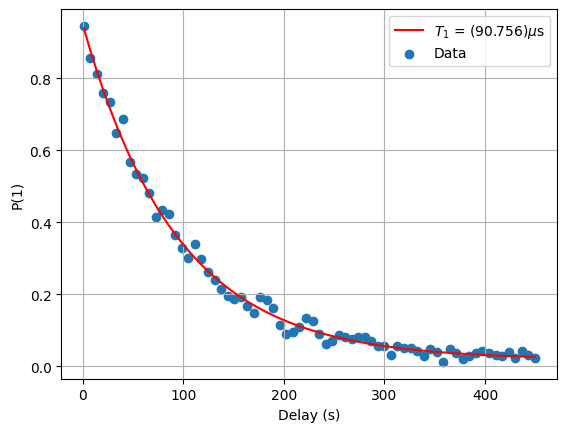

In [20]:
plt.plot(delay_times_sec/us, model(delay_times_sec, *popt), c = 'r', label = r'$T_1$ = (93.541)$\mu$s')
plt.grid()
plt.xlabel(r'Delay (s)')
plt.ylabel('P(1)')
plt.scatter(delay_times_sec/us,prob_1, label = 'Data')
plt.legend()
plt.show()
## This is the T1 of the backend used with Fake_Perth